# TPS Analysis Tutorial

This tutorial will show you how to analyze a TPS simulation.

As with the tutorial on setting up a TPS sampling simulation, you will use several libraries in this notebook. Most prominently, [`OpenPathSampling`](http://openpathsampling.org), which handles most of the analysis of its own simulation. We'll also use:

* [`matplotlib`](http://matplotlib.org/), a library for creating plots
* [`nglview`](https://github.com/arose/nglview/), a library for visualizing MD trajectories in Jupyter notebooks

Note also how we calculate information about the path lengths: these are not OPS-specific tools. Instead, we just use Python's built-in functions.

We'll start by briefly analyzing the simulation you ran. Then we will do some more in-depth analysis of a long TPS simulation.

First, of course, we import the libraries we'll use:

In [6]:
from __future__ import print_function
%matplotlib inline
import openpathsampling as paths
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib
# set some matplotlib parameters
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'figure.figsize': (8.8, 6.6)})

from openpathsampling.numerics import HistogramPlotter2D
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

import nglview as nv
import openmm

## Analysis of your results

Start by loading the file:

In [12]:
storage = paths.AnalysisStorage("tps_simulation_results.nc")

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



The `scheme.move_summary` tells us about acceptance of different types of moves. In complicated schemes, it can show us acceptance of different paths through the move decision tree.

In [13]:
scheme = storage.schemes[0]  # only one in there
scheme.move_summary(storage.steps)

  0%|          | 0/41 [00:00<?, ?it/s]

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 25/40 (62.50%)


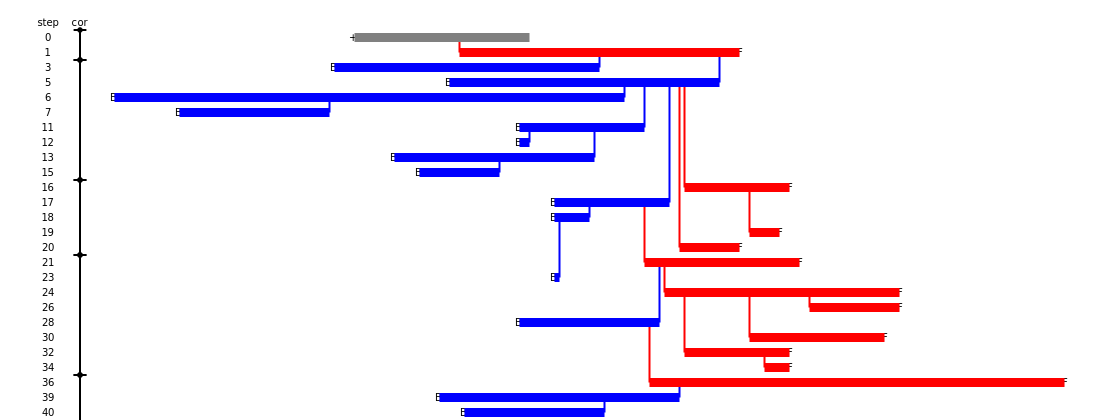

In [14]:
tree = ops_vis.PathTree(
    storage.steps,
    ops_vis.ReplicaEvolution(replica=0)
)

SVG(tree.svg())

  0%|          | 0/41 [00:00<?, ?it/s]

/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/numerics/histogram.py:716: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mesh = plt.pcolormesh(df.fillna(0.0).transpose(), **kwargs)


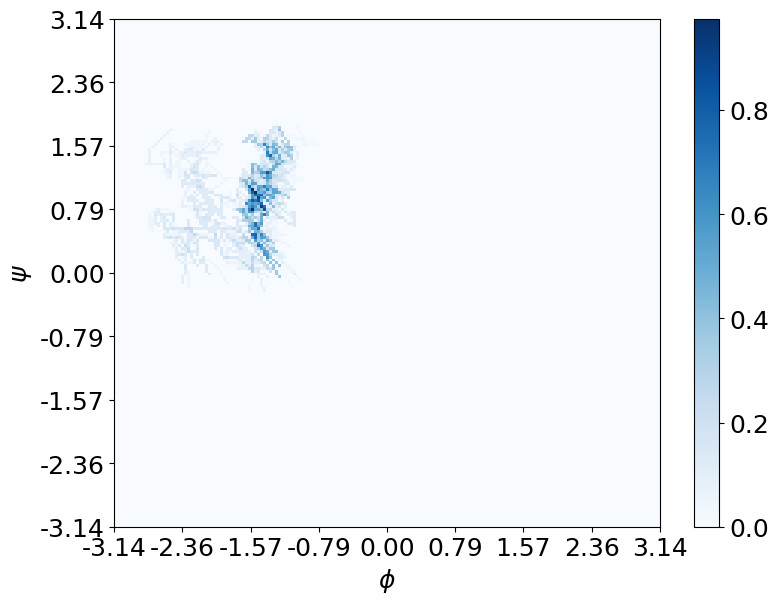

In [15]:
psi = storage.cvs['psi']
phi = storage.cvs['phi']
deg = 180.0 / np.pi

path_density = paths.PathDensityHistogram(cvs=[phi, psi],
                                          left_bin_edges=(-180/deg,-180/deg),
                                          bin_widths=(2.0/deg,2.0/deg))

trajs = [s.active[0].trajectory for s in storage.steps]

path_dens_counter = path_density.histogram(trajs)

tick_labels = np.arange(-np.pi, np.pi + 0.01, np.pi / 4)
plotter = HistogramPlotter2D(path_density,
                             xticklabels=tick_labels,
                             yticklabels=tick_labels,
                             label_format="{:4.2f}")
ax = plotter.plot(cmap="Blues")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$");

From looking at the path tree, we can get a sense of how well our sampling is going. Some questions to consider:

* Do you see acceptance of both forward and backward shots?
* How many decorrelated paths do you see?
* How many accepted moves between decorrelated paths? How many total moves?

If you don't see acceptance of both forward and backward shots, that might indicate a problem in either the state definitions or in the sampling (which might be remedied by using a more advanced shooting point selection algorithm). The number MC steps between decorrelated paths gives a sense of how quickly your simulation is exploring path space. If you see very few decorrelated paths (or none at all), that may indicate that you should switch to a more advanced algorithm such as spring shooting.

Now let's visualize some of your trajectories. The transition that occurs in this simulation is a pretty small, subtle change. To see it, I recommend looking down the ALA-C ALA-C$_\alpha$ bond, and watching the relative orientations of the two nitrogens (this is basically the $\psi$ dihedral angle). We'll use NGLView to visualize it in the notebook, after converting the OPS trajectory to an MDTraj trajectory.

In [24]:
# YOUR TURN: load a trajectory from your simulation.
# Replace #### in the line below with the number of one of your steps
# (and uncomment the line).
traj = storage.steps[6].active[0].trajectory

In [25]:
md_traj = traj.to_mdtraj().image_molecules()
view = nv.show_mdtraj(md_traj)
view.clear()
view.add_ball_and_stick("ACE ALA NME")
view.center()
view

ValueError: Particle position is NaN

Click the two arrows in the upper right to go full screen. You can also pan, zoom, and rotate using the mouse.

If you do not see the widget, you may still need to run the command to enable the widget (and to restart Jupyter):
`jupyter-nbextension enable nglview --py --sys-prefix`

Note that you can also save the trajectory in a format that VMD can read, and then you could use VMD instead.

```python
traj.to_mdtraj().save("filename.dcd")
```

Next let's visualize the shooting point from one of your MC steps. There are two reasons we do this: First, this gives you more practice visualizing OPS data with NGLView. Second, this shows you how to extract the shooting point snapshot from a MC step. Analyzing the shooting points can give ideas on how to troubleshoot problems with sampling (e.g., if you had very few accepted backward shots).

In [ ]:
# YOUR TURN (advanced): Use nglview to visualize the the shooting point from a path
# 1. Pick a step, find the shooting point (in step.change.canonical.details.shooting_snapshot)
# 2. Take that snapshot, wrap it in a trajectory (paths.Trajectory([snapshot]))
# 3. Visualize it with nglview
# Did your selected snapshot come from an accepted or rejected trial?

In [27]:
storage.close()

## Analysis of a long TPS simulation

Now we'll start analyzing a long (10000 shooting move) version of the same simulation you used. To save storage space, the full snapshots were stripped out of this example, so only the pre-calculated results for $\phi$ and $\psi$ are stored. You can get the file from: https://figshare.com/s/01302bc7a39ec7648ea1

Load the file, and from the file pull our the engine (which tells us what the timestep was) and the move scheme (which gives us a starting point for much of the analysis).

In [7]:
%%time
flexible = paths.AnalysisStorage("alanine_dipeptide_tps_split.nc")
# loading as AnalysisStorage massively speeds up the move_summary

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



CPU times: user 59.6 s, sys: 8.79 s, total: 1min 8s
Wall time: 1min 24s


In [8]:
engine = flexible.engines[0]
flex_scheme = flexible.schemes[0]

In [9]:
print("File size: {0} for {1} steps, {2} snapshots".format(
    flexible.file_size_str,
    len(flexible.steps),
    len(flexible.snapshots)
))

File size: 251.19MB for 10001 steps, 946650 snapshots


That tell us a little about the file we're dealing with. Now we'll start analyzing the contents of that file. We used a very simple move scheme (only shooting), so the main information that the `move_summary` gives us is the acceptance of the only kind of move in that scheme. See the MSTIS examples for more complicated move schemes, where you want to make sure that frequency at which the move runs is close to what was expected.

In [32]:
flex_scheme.move_summary(flexible.steps)

  0%|          | 0/10001 [00:00<?, ?it/s]

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 5616/10000 (56.16%)


* How does this acceptance probability compare with the one from your own simulation?

### Replica history tree and decorrelated trajectories

The `PathTree` object gives us both the history tree (often called the "move tree") and the number of decorrelated trajectories.

A `PathTree` is made for a certain set of Monte Carlo steps. First, we make a tree of only the first 40 steps in order to visualize it. (All the steps would be unwieldy.)

After the visualization, we make a second `PathTree` of all the steps, in order to count the number of decorrelated trajectories.

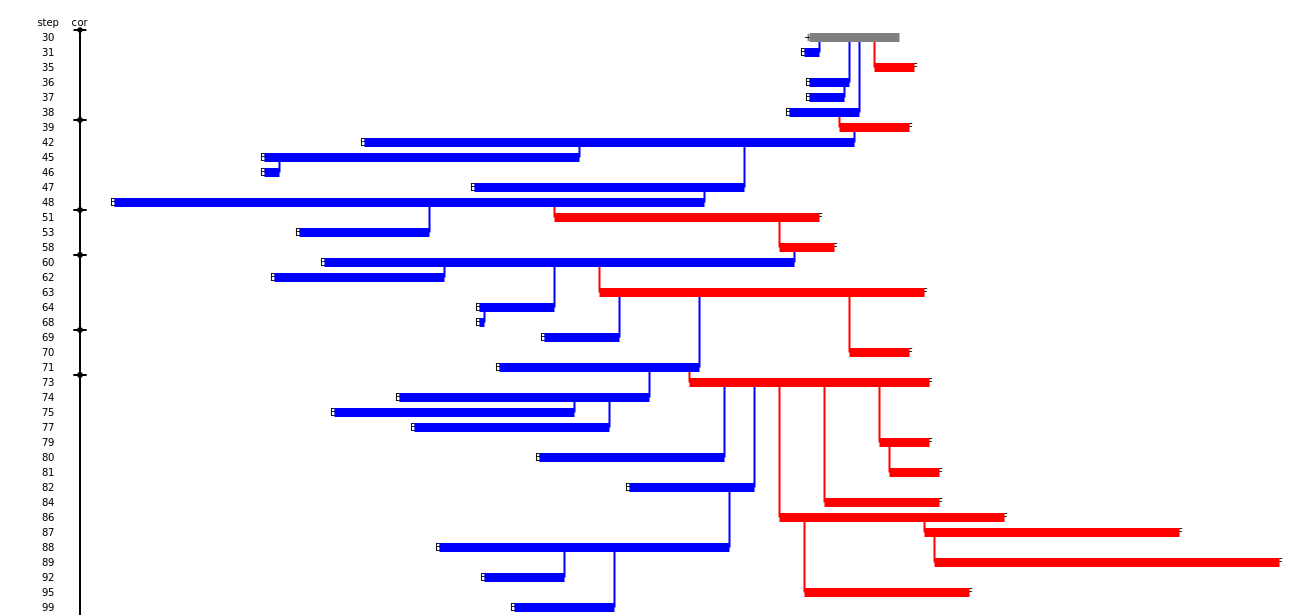

In [54]:
tree = ops_vis.PathTree(
    flexible.steps[30:100],
    ops_vis.ReplicaEvolution(
        replica=0
    )
)

SVG(tree.svg())

In [34]:
%%time
full_tree = ops_vis.PathTree(
    flexible.steps,
    ops_vis.ReplicaEvolution(
        replica=0
    )
)

print("Decorrelated trajectories:", len(full_tree.generator.decorrelated_trajectories))

Decorrelated trajectories: 881
CPU times: user 44.4 s, sys: 721 ms, total: 45.1 s
Wall time: 46.1 s


* How does this path tree compare with the one from your own simulation?
* How many MC steps does it take, on average, to get a decorrelated path in this simulation?
* How many accepted steps are there between decorrelated paths (on average)?

### Path length distribution

Flexible length TPS gives a distribution of path lengths. Here we calculate the length of every accepted trajectory, then histogram those lengths, and calculate the maximum and average path lengths.

We also use `engine.snapshot_timestep` to convert the count of frames to time, including correct units.

Maximum: 528 (1056.0 fs)
Average: 84.14 (168.270 fs)


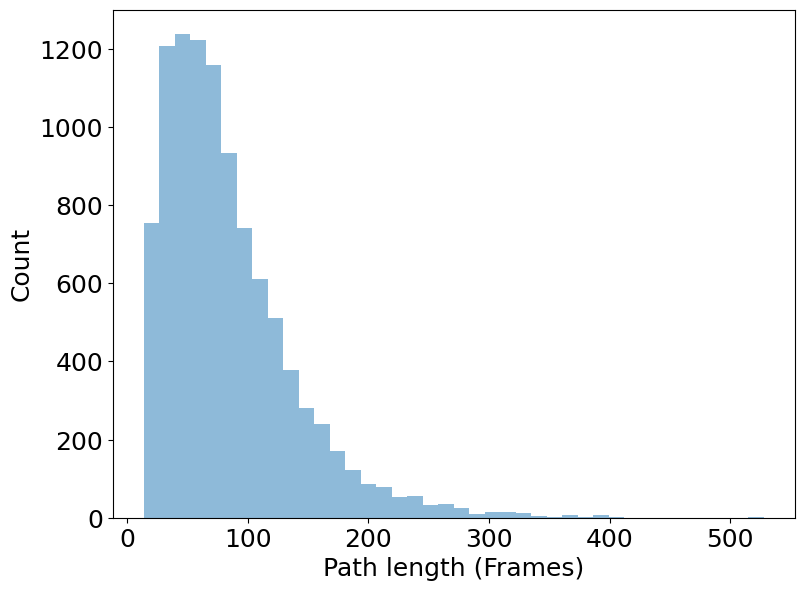

In [35]:
# with OpenMM 8.0 or earlier: timestep = engine.snapshot_timestep
# (also should work for data generated with OpenMM 8.1 or later)
timestep = 2.0 * openmm.unit.femtosecond
path_lengths = [len(step.active[0].trajectory) for step in flexible.steps]
plt.hist(path_lengths, bins=40, alpha=0.5);
print("Maximum:", max(path_lengths), "("+str(max(path_lengths)*timestep)+")")
print("Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+(np.mean(path_lengths)*timestep).format("%.3f")+")")
plt.ylabel("Count")
plt.xlabel("Path length (Frames)");

* Estimate (by eye) what the path length should be if you ensured that fixed-length TPS would include 99% of the paths. How much longer is that than the average path length here? What does that mean about the simulation time required for fixed-length TPS as compared the flexible-length TPS?

### Path density histogram

Next we will create a path density histogram. Calculating the histogram itself is quite easy: first we reload the collective variables we want to plot it in (we choose the phi and psi angles). Then we create the empty path density histogram, by telling it which CVs to use and how to make the histogram (bin sizes, etc). Finally, we build the histogram by giving it the list of active trajectories to histogram.

In [30]:
psi = flexible.cvs['psi']
phi = flexible.cvs['phi']
deg = 180.0 / np.pi

In [31]:
path_density = paths.PathDensityHistogram(cvs=[phi, psi],
                                          left_bin_edges=(-180/deg,-180/deg),
                                          bin_widths=(2.0/deg,2.0/deg))

Next we loop over all trajectories and calculate the path density:

In [3]:
trajs = [s.active[0].trajectory for s in flexible.steps]
path_dens_counter = path_density.histogram(trajs)

NameError: name 'flexible' is not defined

Now we've built the path density histogram, and we want to visualize it. We have a convenient `HistogramPlotter2D` object that works in this case, and takes the histogram, desired plot tick labels and limits, and additional `matplotlib` named arguments to `plt.pcolormesh`.

/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/numerics/histogram.py:716: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mesh = plt.pcolormesh(df.fillna(0.0).transpose(), **kwargs)


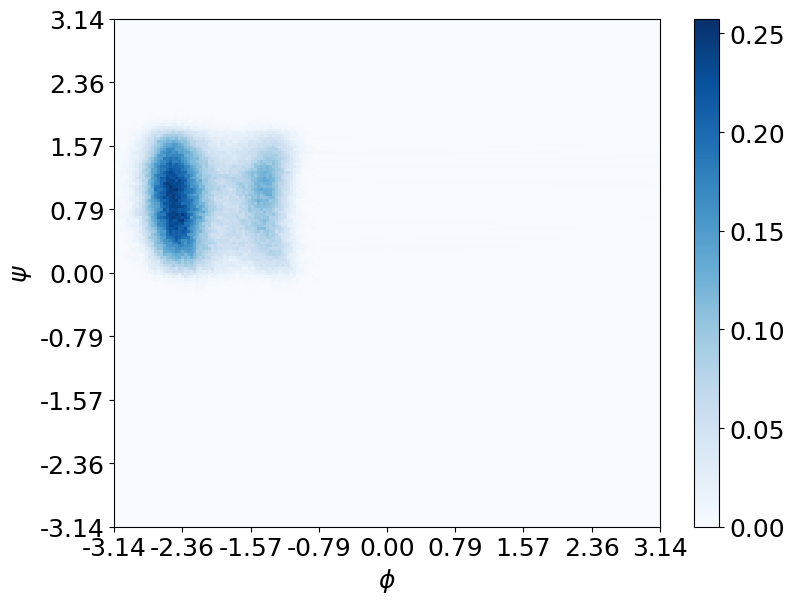

In [33]:
tick_labels = np.arange(-np.pi, np.pi+0.01, np.pi/4)
plotter = HistogramPlotter2D(path_density,
                             xticklabels=tick_labels,
                             yticklabels=tick_labels,
                             label_format="{:4.2f}")
ax = plotter.plot(cmap="Blues")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$");

You should see two areas with a little more density in the paths.

* Which one appears to be more frequent?
* Do they look like completely separate channels, or does it look like some paths involves parts of both?

Next, you'll find a representative trajectory for each channel. This will just involve trial and error until you find one. You're likely to also find trajectories that at least partly cross into the other channel -- these two channels are not very strictly separated.

In [1]:
# YOUR TURN: find such trajectories. Find the right numbers to replace #### below (and uncomment them).
# The next cell will plot the trajectories.
trajA = flexible.steps[0].active[0].trajectory
trajB = flexible.steps[10000].active[0].trajectory

NameError: name 'flexible' is not defined

In [2]:
ax = plotter.plot(xlim=(-np.pi, 0), ylim=(-np.pi/2, np.pi), cmap="Blues")
plotter.plot_trajectory(trajA, '-r', lw=1)
plotter.plot_trajectory(trajB, '-k', lw=1)
plt.xlabel("$\phi$")
plt.ylabel("$\psi$");
#plt.savefig("AD_tps_pathdensity.pdf")  # uncomment this line to save as PDF

NameError: name 'plotter' is not defined

If you have the full simulation data, you could visualize these trajectories with NGLView, using the same approach as above. (Full simulation data not provided online, due to size.)

In [ ]:
md_traj = trajA.to_mdtraj().image_molecules()
view = nv.show_mdtraj(md_traj)
view.clear()
view.add_ball_and_stick("ACE ALA NME")
view.center()
view

In [12]:
import sys

In [13]:

sys.getrecursionlimit()

3000

In [38]:
 flexible.steps[0].active[0].trajectory.to_dict()
#view_A.add_ball_and_stick("ACE ALA NME")
#view_A.center()
#view_A


{'snapshots': [<openpathsampling.engines.snapshot.BaseSnapshot at 0x1346b3c00>,
  <openpathsampling.engines.snapshot.BaseSnapshot at 0x11157e7c0>]}

In [31]:
trajA = flexible.steps[0].active[0].trajectory

In [32]:
storage.steps[0].active[0].trajectory[1::10]


Trajectory[22]